# Effect of the tolerance parameter on Huron's typology

In this notebook we search for the value of the tolerance parameter for which Huron's typology has maximal entropy.
That is, for which the classes are as big as possible. We do do this by a simple grid search.

In [1]:
# Import 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap

import sys
sys.path.append('../')
from helpers import cm2inch, title
matplotlib.style.use('styles.mplstyle')

from src.typology import HuronTypology, TypologyOptimizer
from src.contour import Contour
from src.dataset import Dataset

import warnings
warnings.filterwarnings("ignore", category=Warning)

# Directory where all figures from this notebook are stored
FIG_DIR = '../figures/tolerance-parameter'
SAVE_FIG = True

In [2]:
cmap = [plt.get_cmap('tab10')(i) for i in range(9)]
types = {
    'horizontal': dict(color=cmap[0], label='horiz', ls='-'), 
    'descending': dict(color=cmap[1], label='desc', ls='--'), 
    'concave': dict(color=cmap[2], label='concave', ls='-'), 
    'ascending': dict(color=cmap[3], label='asc', ls=':'), 
    'convex': dict(color=cmap[4], label='convex', ls='-.'), 
    'horizontal-descending': dict(color=cmap[5], label='h-desc'), 
    'descending-horizontal': dict(color=cmap[6], label='desc-h'),
    'ascending-horizontal': dict(color=cmap[7], label='asc-h'),
    'horizontal-ascending': dict(color=cmap[8], label='h-asc'),
}
selection = ['horizontal', 'descending', 'ascending', 'convex', 'concave']

## Estimate tolerance on cross-cultural dataset

In [3]:
dataset = Dataset('combined-phrase')
raw_contours = dataset.contours('pitch_centered', limit=1000)
contours = [Contour(c) for c in raw_contours]

In [4]:
class HuronOptimization:
    def __init__(self, contours, xs=np.linspace(0, 10, 50)):
        self.optimizer = TypologyOptimizer(HuronTypology)
        self.loss = self.optimizer.loss_function(contours, ['tolerance'])
        self.best, self.res = self.optimizer.optimize(contours, dict(tolerance=[0, 10]))
        self.best_entropy = -1 * self.res['fun']
        self.best_epsilon = self.best['tolerance']
        self.xs = xs
        self.losses = [-1*self.loss([x]) for x in self.xs]

In [5]:
opt = HuronOptimization(contours)
opt.best_epsilon

1.2911317900748998

We search for the best parameter using `scipy.optimize.differential_evolution`:

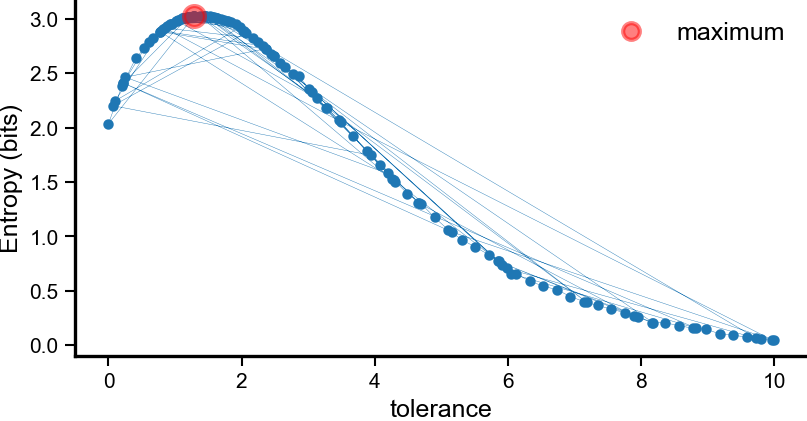

In [6]:
def show_optimization(trace, res, param='tolerance'):
    tols = [t['params'][param] for t in trace]
    scores = [t['score'] for t in trace]
    plt.plot(tols, scores, '.-', lw=.1)
    plt.plot([res.x], [-1*res.fun], 'ro', alpha=.5, ms=5, label='maximum')
    plt.ylabel('Entropy (bits)')
    plt.xlabel(param)
    plt.legend()
    sns.despine()

plt.figure(figsize=cm2inch(8, 4), dpi=150)
show_optimization(opt.optimizer.trace, opt.res)

In [7]:
def decorate_entropy_plot(text_x=10, ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)
    plt.ylabel('Entropy (bits)')
    plt.xlabel('Tolerance $\epsilon$ (semitones)');
    plt.axhline(np.log2(4), ls=':', c='0.5', lw=.5)
    plt.text(text_x, np.log2(4)-.1, '$\log_2(4)$', 
            va='top', ha='right', c='0.5', fontsize=6)
    plt.axhline(np.log2(9), ls=':', c='0.5', lw=.5)
    plt.text(text_x, np.log2(9)-.1, '$\log_2(9)$', 
            va='top', ha='right', c='0.5', fontsize=6)
    plt.ylim(0, 3.5)
    sns.despine()

def show_entropy(xs, losses, best_epsilon, best_entropy, ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)
    plt.plot(xs, losses, 'k-', lw=1)
    plt.plot(best_epsilon, best_entropy, 'o', markerfacecolor="None", ms=5, color='C3', markeredgewidth=.5)
    plt.axvline(best_epsilon, ls='--', color='C3', lw=.5, label='optimal $\epsilon$ for erk')
    plt.text(best_epsilon, -.3, f'{best_epsilon:.2f}', color='C3', va='top', ha='center', size=5)
    decorate_entropy_plot(ax=ax, text_x=xs[-1])

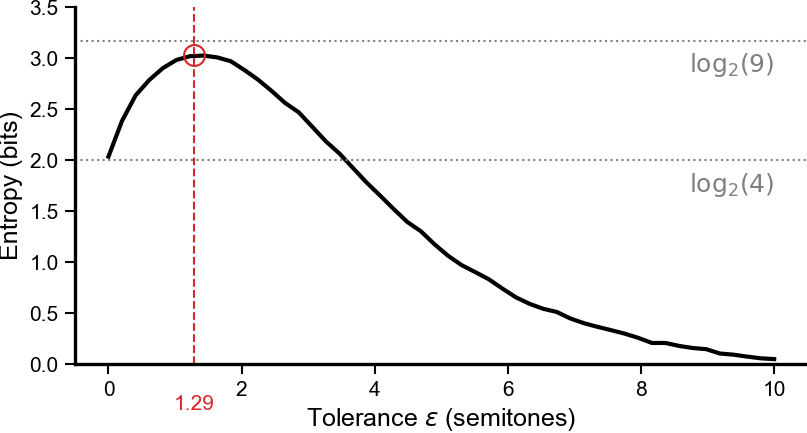

In [8]:
plt.figure(figsize=cm2inch(8,4), dpi=150)
show_entropy(opt.xs, opt.losses, opt.best_epsilon, opt.best_entropy)

## Entropy per tradition

In [9]:
dataset_ids = ['erk-phrase', 'han-phrase', 'liber-antiphons-phrase']
results = {}
for dataset_id in dataset_ids:
    cont = Dataset(dataset_id).contours('pitch_centered', limit=1000)
    cont = [Contour(c) for c in cont]
    results[dataset_id] = HuronOptimization(cont)

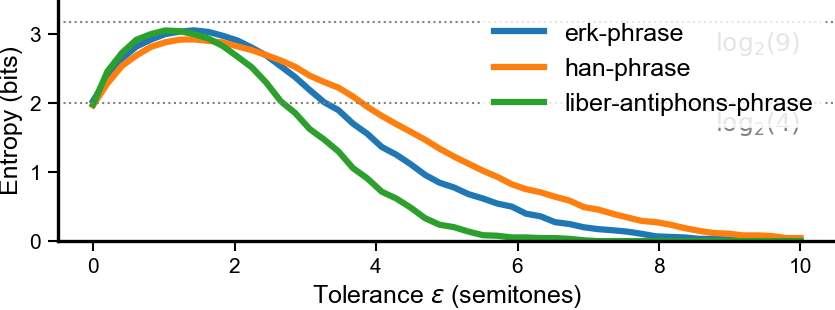

In [10]:
plt.figure(figsize=cm2inch(8, 3.5), dpi=150)
for dataset_id, experiment in results.items():
    plt.plot(experiment.xs, experiment.losses, label=dataset_id)
plt.legend()
decorate_entropy_plot()
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f'{FIG_DIR}/subplots/tolerance-vs-entropy.pdf')

## Type distribution

In [11]:
def get_type_freqs(contours, epsilons, types=types.keys()):
    distributions = np.zeros((len(epsilons), 9))
    for i, epsilon in enumerate(epsilons):
        T = HuronTypology(tolerance=epsilon)
        contour_types = [T.classify(c) for c in contours]
        freqs = pd.value_counts(contour_types, normalize=True)
        distributions[i, :] = [freqs.get(t, 0) for t in types]

    freqs = pd.DataFrame(distributions, index=epsilons, columns=types).T
    freqs.index.name = 'type'
    return freqs

In [12]:
def show_freq_function(epsilons, freqs, selection=selection, ax=None):
    if ax is None: ax=plt.gca()
    for label, ys in freqs.iterrows():
        if label not in selection:
            ax.plot(epsilons, ys, 'k-', lw=.5, ms=4, alpha=.5)
    for t in selection:
        ax.plot(epsilons, freqs.loc[t, :], lw=1, **types[t])

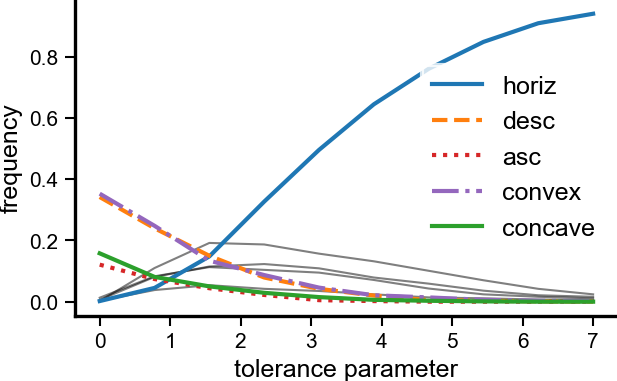

In [13]:
xs = np.linspace(0, 7, 10)
plt.figure(figsize=cm2inch(6,4), dpi=150)
freqs = get_type_freqs(contours, xs)
show_freq_function(xs, freqs)
plt.legend()
plt.ylabel('frequency')
plt.xlabel('tolerance parameter')
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f'{FIG_DIR}/subplots/type-frequencies.pdf')

In [14]:
def show_histograms(contours, epsilons, axs, palette='tab10', **kwargs):
    freqs = get_type_freqs(contours, epsilons).reset_index()
    for ax, epsilon in zip(axs, epsilons):
        sns.barplot(data=freqs, x='type', y=epsilon, ax=ax, 
            order = types.keys(),
            saturation=1,
            palette=palette, **kwargs) 
        sns.despine(left=True, ax=ax)
        ax.set_yticks([])
        ax.set_ylabel('')
        ax.set_xlabel('')
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    axs[-1].set_xticklabels(axs[-1].get_xticklabels(), rotation=45, horizontalalignment='right')

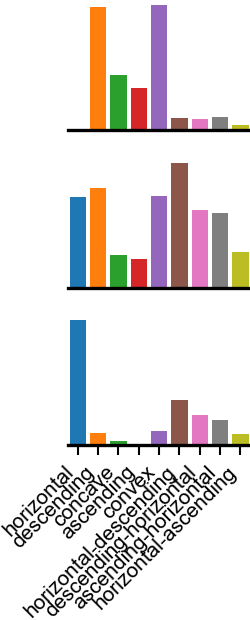

In [15]:
epsilons = [0.2, 1.5, 3]
fig, axs = plt.subplots(3, figsize=cm2inch(2, 5), dpi=150)
show_histograms(contours, epsilons, axs)

In [16]:
mapper = umap.UMAP().fit(raw_contours)

### UMAP plots

In [17]:
def show_umap_plots(mapper, contours, epsilons, axs, s=1, alpha=1,):
    labels = {}
    for eps in epsilons:
        T = HuronTypology(tolerance=eps)
        labels[eps] = np.array([T.classify(c) for c in contours])

    for ax, eps in zip(axs, epsilons):
        for i, label in enumerate(selection):
            x, y = mapper.embedding_[labels[eps] == label, :].T
            ax.scatter(x, y, s=s, alpha=alpha, **types[label], lw=0)
            ax.axis('off')

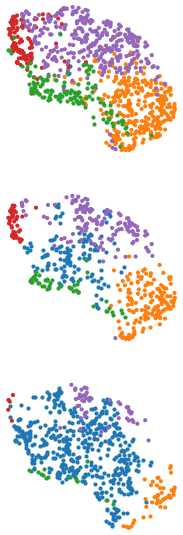

In [18]:
fig, axs = plt.subplots(3, figsize=cm2inch(2, 6), dpi=150)
show_umap_plots(mapper, contours, epsilons, axs)

## Combined plot

In [19]:
combined_contours = [Contour(c) for c in Dataset('combined-phrase').contours('pitch_centered', limit=5000)]
erk_contours = [Contour(c) for c in Dataset('erk-phrase').contours('pitch_centered', limit=5000)]
han_contours = [Contour(c) for c in Dataset('han-phrase').contours('pitch_centered', limit=5000)]

In [20]:
xs = np.linspace(0, 7, 50)
opt = HuronOptimization(combined_contours, xs=xs)
opt.best_epsilon

1.3496054561970228

In [21]:
freqs = get_type_freqs(combined_contours, opt.xs)

In [22]:
raw_contours = np.array([c.pitches for c in combined_contours])
mapper = umap.UMAP().fit(raw_contours)

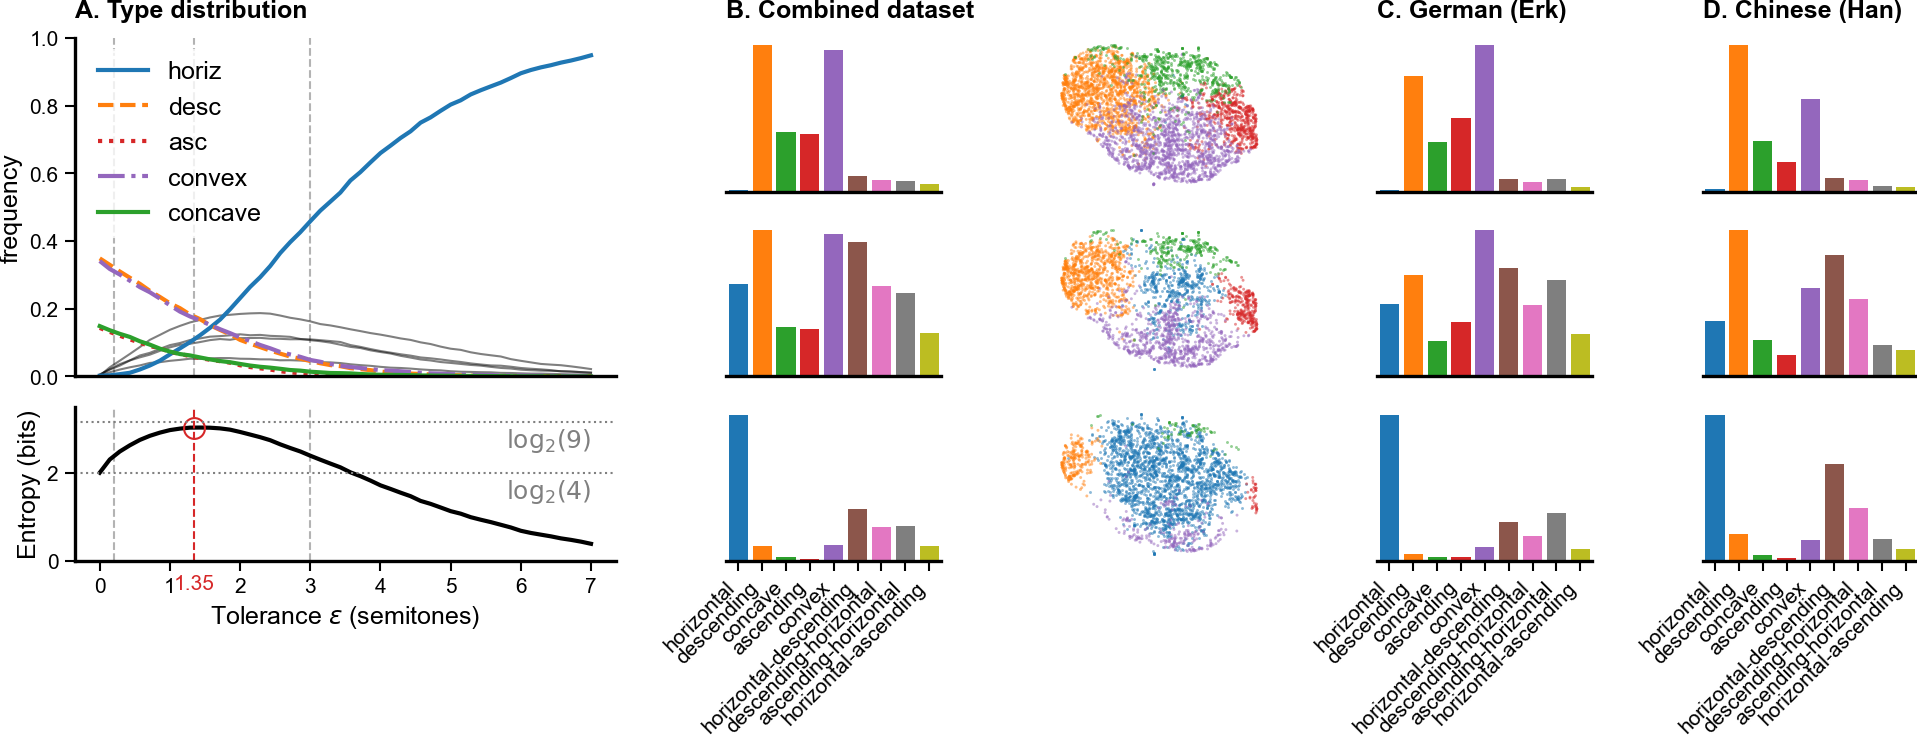

In [23]:
epsilons = [0.2, opt.best_epsilon, 3]

fig = plt.figure(
    figsize=cm2inch(17, 7),
    dpi=150,
    tight_layout=True
)
gs = fig.add_gridspec(nrows=1, ncols=6)

col1 = gs[:, :2].subgridspec(nrows=3, ncols=1)
ax00 = fig.add_subplot(col1[:2, 0])
title('A. Type distribution', ax=ax00)
show_freq_function(xs, freqs, ax=ax00)
ax00.set_ylabel('frequency')
ax00.set_xticks([])
ax00.set_ylim(0, 1)
ax00.legend()
for eps in epsilons:
    ax00.axvline(eps, ls='--', color='0.7', lw=.5, zorder=-1)

ax10 = fig.add_subplot(col1[2, 0])
show_entropy(opt.xs, opt.losses, opt.best_epsilon, opt.best_entropy)
ax10.set_ylim(0, 3.5)
for eps in [epsilons[0], epsilons[-1]]:
    ax10.axvline(eps, ls='--', color='0.7', lw=.5, zorder=-1)

col2_gs = gs[:, 2].subgridspec(nrows=3, ncols=1)
col2_axs = [fig.add_subplot(g) for g in col2_gs]
show_histograms(combined_contours, epsilons, col2_axs)
for ax in col2_axs[:2]: ax.set_xticks([])
title('B. Combined dataset', ax=col2_axs[0])

col3_gs = gs[:, 3].subgridspec(nrows=3, ncols=1)
col3_axs = [fig.add_subplot(g) for g in col3_gs]
show_umap_plots(mapper, combined_contours, epsilons, col3_axs, s=.5, alpha=.5)

col4_gs = gs[:, 4].subgridspec(nrows=3, ncols=1)
col4_axs = [fig.add_subplot(g) for g in col4_gs]
show_histograms(erk_contours, epsilons, col4_axs)
title('C. German (Erk)', ax=col4_axs[0])

col5_gs = gs[:, 5].subgridspec(nrows=3, ncols=1)
col5_axs = [fig.add_subplot(g) for g in col5_gs]
show_histograms(han_contours, epsilons, col5_axs)
title('D. Chinese (Han)', ax=col5_axs[0])
if SAVE_FIG: 
    plt.savefig(f'{FIG_DIR}/tolerance-parameter-raw.pdf')


## Cluster coherence

We also analyzed how two measures of cluster coherence vary as a function of $\epsilon$. However, the result that contours do not cluster at all, makes it hard to interpret these metrics.

In [24]:
from sklearn import metrics

In [25]:
def get_types(typology, contours):
    types = [typology.classify(c) for c in contours]
    X = [c.pitches for c in contours]
    return X, types

def silhouette_score(typology, contours): 
    X, types = get_types(typology, contours)
    return metrics.silhouette_score(X, labels=types)

def calinski_harabasz_score(typology, contours): 
    X, types = get_types(typology, contours)
    return metrics.calinski_harabasz_score (X, labels=types)

def get_scores(scoring_fn, contours, xs=np.linspace(0, 10, 50)):
    opt = TypologyOptimizer(HuronTypology, scoring_fn=scoring_fn)
    f = opt.loss_function(contours, ['tolerance'])
    ys = [-1 * f([x]) for x in xs]
    return ys

In [26]:
# This takes long!
xs = np.linspace(0, 5, 100)
values = {}
values['silhouette'] = get_scores(silhouette_score, combined_contours[:5000], xs)
values['calinski_harabasz'] = get_scores(calinski_harabasz_score, combined_contours[:5000], xs)

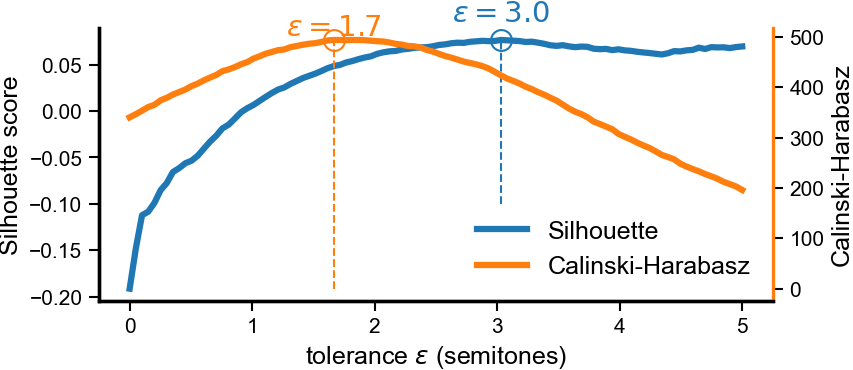

In [27]:
#https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
fig, host = plt.subplots(figsize=cm2inch(8, 4), dpi=150)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
host.set_ylabel('Silhouette score')
par1.set_ylabel('Calinski-Harabasz')
par1.spines["right"].set_color('C1')
par1.spines["right"].set_visible(True)

l1, = host.plot(xs, values['silhouette'], c='C0', label='Silhouette')
l2, = par1.plot(xs, values['calinski_harabasz'], c='C1', label='Calinski-Harabasz')

lines = [l1, l2]
par1.legend(lines, [l.get_label() for l in lines])
host.set_xlabel('tolerance $\epsilon$ (semitones)')
# host.set_ylim(-.1, .2)
# par1.set_ylim(0, 600)

sil_idx = np.argmax(values['silhouette'])
sil_x = xs[sil_idx]
sil_y = values['silhouette'][sil_idx]
host.plot(sil_x,sil_y, 'o', markerfacecolor="None", ms=5, markeredgewidth=.5)
host.plot([sil_x, sil_x], [-.1, sil_y], color='C0', ls='--', lw=.5)
host.text(sil_x, sil_y+.02, f'$\epsilon={sil_x:.2}$', ha='center', c='C0', fontsize=7)

ch_idx = np.argmax(values['calinski_harabasz'])
ch_x = xs[ch_idx]
ch_y = values['calinski_harabasz'][ch_idx]
par1.plot(ch_x, ch_y, 'o', c='C1', markerfacecolor="None", ms=5, markeredgewidth=.5)
par1.plot([ch_x, ch_x], [0, ch_y], color='C1', ls='--', lw=.5)
par1.text(ch_x, ch_y+10, f'$\epsilon={ch_x:.2}$', ha='center', c='C1', fontsize=7)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(f'{FIG_DIR}/subplots/cluster-coherence-raw.pdf')